## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from joblib import dump 

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

from src.config import CLEAN_TS_DIR, FORECAST_EXPERIMENTS_DIR, WINNER_MODEL_DIR


import warnings, math, time, json
# Suppress non-critical warnings (e.g. sklearn feature-name warnings during recursive rollouts).
# Feature order is explicitly controlled and numerical results are unaffected.
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="X does not have valid feature names")

In diesem Abschnitt werden alle für das Experiment benötigten Bibliotheken geladen. Neben Standardbibliotheken für numerische Berechnungen, Datenmanipulation und Visualisierung (NumPy, pandas, Matplotlib) umfasst dies insbesondere Komponenten aus *scikit-learn* für zeitserienspezifische Validierung, Modelltraining, Hyperparameteroptimierung und Evaluation.

Die Auswahl der Regressionsmodelle (Ridge, Random Forest, HistGradientBoosting) spiegelt bewusst unterschiedliche Modellklassen wider (linear vs. baumbasiert), um strukturelle Unterschiede im Prognoseverhalten untersuchen zu können. Ergänzend werden Hilfsbibliotheken für Pfad- und Zeitstempelmanagement sowie für die Persistierung von Modellen und Metadaten eingebunden.

Warnmeldungen werden gezielt unterdrückt, da im rekursiven Forecasting NumPy-Arrays ohne Feature-Namen an Modelle übergeben werden, die zuvor mit benannten Features trainiert wurden. Die Feature-Reihenfolge ist im gesamten Experiment explizit kontrolliert, sodass diese Warnungen keinen Einfluss auf die numerische Korrektheit oder die Interpretation der Ergebnisse haben. Die Unterdrückung dient ausschließlich der Reduktion nicht-informativer Notebook-Ausgaben.


## 2. Global Configuration & Experiment Settings

In [2]:
TIMESTAMP_COL = "timestamp"
TARGET = "P_MW"

RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]
TARGET_LAGS = [1, 4, 8, 12, 24, 96]

FOURIER_K = 3
PERIOD_STEPS = 96

MIN_COVERAGE = 0.20

H = 100                          
# day-ahead horizon with extra time for calculations

FINAL_HOLDOUT_FRAC = 0.20

OUTER_SPLITS = 3
INNER_SPLITS = 3
N_ITER = 10
RANDOM_STATE = 42
N_JOBS = 1

ORIGIN_STRIDE = 8                # every 2 hours (15min steps)
MAX_TEST_ORIGINS_PER_FOLD = 400  # cap rollouts during model-selection

# Horizon buckets for reporting
H_BUCKETS = [
    (1, 4),
    (5, 12),
    (13, 24),
    (25, 48),
    (49, 100),
]

# Output folder
RUN_TS = datetime.now().strftime("%Y%m%d_%H%M%S")
OUT_DIR = FORECAST_EXPERIMENTS_DIR / RUN_TS
OUT_DIR.mkdir(parents=True, exist_ok=True)

LATEST_DIR = WINNER_MODEL_DIR
LATEST_DIR.mkdir(parents=True, exist_ok=True)


In diesem Abschnitt werden die zentralen Steuerparameter des Prognoseexperiments definiert. Projektweite Annahmen wie Zeitauflösung, Zeitzone, Datenverzeichnisse und Bereinigungsstandards sind bereits in der zentralen Konfigurationsdatei (`config.py`) festgelegt und werden hier lediglich referenziert, nicht erneut definiert. Die folgenden Parameter betreffen ausschließlich die Ausgestaltung und Reproduzierbarkeit des konkreten Experiments.

Die Zielgröße der Prognose ist die elektrische Wirkleistung P_MW, die auf einer regularisierten 15-Minuten-Zeitachse modelliert wird. Als exogene Einflussgrößen werden meteorologische Variablen (Windgeschwindigkeit, solare Einstrahlung und Außentemperatur) berücksichtigt. Ergänzend werden autoregressive Lag-Features mit unterschiedlichen zeitlichen Abständen verwendet, um sowohl kurzfristige Dynamiken als auch tagesperiodische Abhängigkeiten der Last abzubilden.

Zur expliziten Modellierung periodischer Strukturen werden Fourier-Komponenten mit einer Tagesperiode von 96 Zeitschritten eingesetzt. Diese Features dienen dazu, wiederkehrende intra-tägliche Muster unabhängig von der absoluten Zeitlage zu erfassen.

Der Prognosehorizont beträgt 100 Zeitschritte und entspricht damit einem Day-Ahead-Szenario von rund 25 Stunden. Die Bewertung der Modelle erfolgt ausschließlich auf dieser Multi-Step-Ebene. Der Datensatz wird zeitlich in einen Trainingsbereich und einen strikt nachgelagerten Holdout-Bereich aufgeteilt, wobei der Holdout-Anteil 20 % der verfügbaren Daten umfasst und ausschließlich für die finale Modellevaluierung genutzt wird.

Die Modellselektion basiert auf einer zeitserienspezifischen, verschachtelten Cross-Validation mit separaten inneren und äußeren Splits. Die äußeren Splits dienen der robusten Bewertung der Day-Ahead-Performance im Trainingszeitraum, während die inneren Splits zur Hyperparameteroptimierung verwendet werden. Zur Begrenzung der Rechenzeit werden Startpunkte für rekursive Rollouts zeitlich ausgedünnt und pro Fold gedeckelt. Diese Einschränkungen stellen einen bewussten Kompromiss zwischen statistischer Stabilität der Fehlerabschätzung und praktischer Durchführbarkeit dar.

Für die Ergebnisdarstellung werden horizontabhängige Fehler zusätzlich in vordefinierten Horizon-Buckets aggregiert. Dies ermöglicht eine kompakte, anwendungsnahe Bewertung der Prognosequalität über unterschiedliche Vorlaufbereiche hinweg.

Alle im Experiment erzeugten Ergebnisse, Modelle und Metadaten werden in einem laufzeitspezifischen Ausgabeverzeichnis abgelegt. Das jeweils beste Modell wird zusätzlich in einem stabilen Zielverzeichnis persistiert, sodass es unabhängig vom Experimentlauf für nachgelagerte Anwendungen verfügbar ist.


## 3. Utility Functions & Metrics

In [3]:
# Metrics, bucket aggregation, skill score

def evaluate(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mae = float(mean_absolute_error(y_true, y_pred))
    rmse = float(math.sqrt(mean_squared_error(y_true, y_pred)))
    r2 = float(r2_score(y_true, y_pred))
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def bucket_means(mae_h, buckets):
    out = {}
    for a, b in buckets:
        # horizons are 1-indexed in naming, but array is 0-indexed
        seg = mae_h[(a-1):b]
        out[f"MAE_h{a:03d}-{b:03d}"] = float(np.nanmean(seg))
    return out

def skill_score(mae_model, mae_baseline):
    return float(1.0 - (mae_model / mae_baseline))

Zur einheitlichen Bewertung der Prognoseergebnisse werden zentrale Fehlerkennzahlen in kompakten Hilfsfunktionen zusammengefasst. Die Funktion `evaluate` berechnet mit MAE, RMSE und \(R^2\) sowohl absolute als auch relative Gütemaße, die für die modellübergreifende Einordnung der Day-Ahead-Prognosen verwendet werden. Der MAE dient dabei als primäre Metrik, da er robust interpretierbar ist und direkt auf der Skala der Zielgröße liegt.

Da sich Prognosefehler über den Vorhersagehorizont typischerweise systematisch verändern, wird der MAE zusätzlich horizonweise ausgewertet. Die Funktion `bucket_means` fasst diese horizonabhängigen Fehler über vordefinierte Intervalle zusammen und ermöglicht so eine kompakte, anwendungsnahe Darstellung der Prognosegüte für unterschiedliche Vorlaufbereiche.

Ergänzend wird mit dem Skill Score eine relative Kenngröße gegenüber der Persistenzbaseline berechnet. Dieser Wert dient ausschließlich der Einordnung des erzielten Mehrwerts eines Modells gegenüber einer einfachen Referenz und ersetzt nicht die Bewertung anhand absoluter Fehlermaße.


## 4. Feature Engineering Utilities

In [4]:
# Time, Fourier and lag feature helpers

def add_time_features(df):
    ts = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month

    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"]  = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"]  = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"]= np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"]= np.cos(2 * np.pi * df["month"] / 12)
    return df

def add_fourier_features(df, period_steps=PERIOD_STEPS, K=FOURIER_K, prefix="day"):
    step_idx = (np.arange(len(df), dtype=float) % period_steps)
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df

def add_target_lags(df, target_col, lags):
    for L in lags:
        df[f"{target_col}_lag{L}"] = df[target_col].shift(L)
    return df

def prepare_df(df_raw):
    df = df_raw.copy()
    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)

    df = add_time_features(df)
    df = add_fourier_features(df)
    df = add_target_lags(df, TARGET, TARGET_LAGS)

    df["target_1"] = df[TARGET].shift(-1)

    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    time_feats = ["hour_sin","hour_cos","dow_sin","dow_cos","month_sin","month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K+1)] + [f"day_cos{k}" for k in range(1, FOURIER_K+1)]
    lag_feats = [f"{TARGET}_lag{L}" for L in TARGET_LAGS]

    exog_cols = present_feats + time_feats + fourier_feats
    lag_cols = lag_feats
    feature_cols = exog_cols + lag_cols

    df_model = df.dropna(subset=feature_cols + ["target_1", TARGET]).copy().reset_index(drop=True)
    return df_model, feature_cols, exog_cols, lag_cols, present_feats

Zur Aufbereitung der Zeitreihen für das überwachte Lernen werden mehrere Feature-Gruppen kombiniert. Zunächst werden aus dem Zeitstempel kalendarische Informationen (Stunde, Wochentag, Monat) abgeleitet und über Sinus- und Kosinus-Transformationen in eine zyklische Darstellung überführt. Dadurch können periodische Effekte modelliert werden, ohne künstliche Sprünge an Periodengrenzen zu erzeugen.

Ergänzend werden Fourier-Features mit einer Tagesperiode von 96 Zeitschritten erzeugt. Diese erfassen wiederkehrende intra-tägliche Muster unabhängig von der absoluten Zeitlage und erlauben eine flexible Approximation periodischer Lastverläufe über mehrere Harmonische.

Zur Abbildung der zeitlichen Abhängigkeit der Last werden autoregressive Lag-Features der Zielgröße mit unterschiedlichen Vorlaufzeiten ergänzt. Diese ermöglichen es den Modellen, sowohl kurzfristige Trägheit als auch längerfristige Abhängigkeiten im Lastverlauf zu berücksichtigen.

Die Funktion `prepare_df` fasst diese Schritte zusammen: Sie sortiert die Zeitreihe, erzeugt alle zeitlichen, periodischen und autoregressiven Features und definiert das One-Step-Ziel für das Training. Abschließend werden nur vollständig beobachtete Zeitpunkte retained, sodass ein konsistenter, leackagefreier Datensatz für das nachgelagerte Forecasting entsteht.


## 5. Model Definitions & Hyperparameter Spaces

In [5]:
def make_models_and_spaces():
    models = {}

    models["Ridge"] = (
        Pipeline([("scaler", StandardScaler()), ("model", Ridge(random_state=RANDOM_STATE))]),
        {"model__alpha": np.logspace(-3, 3, 20).tolist()},
    )

    models["RF"] = (
        RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS),
        {
            "n_estimators": [200, 400, 800],
            "max_depth": [None, 8, 12, 16, 24],
            "min_samples_leaf": [1, 2, 5, 10],
            "max_features": ["sqrt", 0.5, 0.8, None],
        },
    )

    models["HGB"] = (
        HistGradientBoostingRegressor(random_state=RANDOM_STATE),
        {
            "learning_rate": [0.03, 0.05, 0.08, 0.1],
            "max_depth": [None, 6, 10, 14],
            "max_leaf_nodes": [31, 63, 127],
            "min_samples_leaf": [10, 20, 50],
            "l2_regularization": [0.0, 0.1, 1.0],
        },
    )

    return models

Für die Prognose werden drei Regressionsmodelle unterschiedlicher Komplexität betrachtet. Die Ridge-Regression dient als linearer, regularisierter Referenzansatz und wird mit vorgeschalteter Standardisierung eingesetzt, um die Vergleichbarkeit der Koeffizienten und eine stabile Optimierung sicherzustellen. Der zugehörige Hyperparameterraum umfasst ausschließlich die Regularisierungsstärke und erlaubt so eine gezielte Kontrolle des Bias-Varianz-Trade-offs.

Als nichtlineare Vergleichsmodelle werden ein Random Forest und ein HistGradientBoosting-Regressor verwendet. Beide Ansätze können nichtlineare Zusammenhänge und Interaktionen zwischen Features modellieren, unterscheiden sich jedoch in ihrer Trainingslogik und Regularisierung. Die definierten Hyperparameterräume variieren Modellkomplexität, Baumtiefe und Regularisierung gezielt, ohne eine unnötig große Suchdimension zu erzeugen.

Die Rückgabe der Modelle erfolgt gemeinsam mit den jeweiligen Suchräumen, sodass die nachgelagerte Hyperparameteroptimierung und Modellselektion einheitlich und reproduzierbar durchgeführt werden kann.


## 6. Day-Ahead Evaluation Functions

In [6]:
# Recursive and basline evaluation
def _update_lags_from_history(lag_cols, history_values):
    # lag col format: "P_MW_lag96" etc.
    return np.array([history_values[int(col.split("lag")[1])] for col in lag_cols], dtype=float)

def evaluate_day_ahead_recursive(model, df_model, exog_cols, lag_cols, H=100, origin_indices=None, origin_stride=1):
    n = len(df_model)
    max_origin = n - H - 1
    if max_origin <= 0:
        raise ValueError(f"Not enough data for H={H}. n={n}")

    if origin_indices is None:
        origin_indices = np.arange(0, max_origin + 1, origin_stride, dtype=int)
    else:
        origin_indices = np.asarray(origin_indices, dtype=int)
        origin_indices = origin_indices[origin_indices <= max_origin]

    abs_errors_h = [[] for _ in range(H)]
    sq_errors_h = [[] for _ in range(H)]
    y_true_all, y_pred_all = [], []

    lag_steps = [int(c.split("lag")[1]) for c in lag_cols]
    max_lag = max(lag_steps)

    for j in origin_indices:
        history = {}
        for L in range(1, max_lag + 1):
            idx = j - (L - 1)
            history[L] = float(df_model[TARGET].iloc[idx]) if idx >= 0 else np.nan
        if any(np.isnan(history[L]) for L in lag_steps):
            continue

        for k in range(1, H + 1):
            step_idx = j + (k - 1)  # feature time
            exog = df_model.loc[step_idx, exog_cols].astype(float).values if exog_cols else np.array([], dtype=float)
            lag_vec = _update_lags_from_history(lag_cols, history)
            x = np.concatenate([exog, lag_vec]).reshape(1, -1)

            y_hat = float(model.predict(x)[0])
            y_true = float(df_model[TARGET].iloc[j + k])

            err = y_true - y_hat
            abs_errors_h[k-1].append(abs(err))
            sq_errors_h[k-1].append(err * err)

            y_true_all.append(y_true)
            y_pred_all.append(y_hat)

            # shift lags and add prediction
            for L in range(max_lag, 1, -1):
                history[L] = history[L-1]
            history[1] = y_hat

    mae_h = np.array([np.mean(v) if len(v) else np.nan for v in abs_errors_h], dtype=float)
    rmse_h = np.array([math.sqrt(np.mean(v)) if len(v) else np.nan for v in sq_errors_h], dtype=float)
    overall = evaluate(np.array(y_true_all), np.array(y_pred_all))
    return overall, mae_h, rmse_h

def evaluate_day_ahead_persistence(df_model, H=100, origin_stride=1):
    n = len(df_model)
    max_origin = n - H - 1
    origin_indices = np.arange(0, max_origin + 1, origin_stride, dtype=int)

    abs_errors_h = [[] for _ in range(H)]
    sq_errors_h = [[] for _ in range(H)]
    y_true_all, y_pred_all = [], []

    for j in origin_indices:
        y0 = float(df_model[TARGET].iloc[j])
        for k in range(1, H + 1):
            y_true = float(df_model[TARGET].iloc[j + k])
            y_hat = y0
            err = y_true - y_hat
            abs_errors_h[k-1].append(abs(err))
            sq_errors_h[k-1].append(err * err)
            y_true_all.append(y_true)
            y_pred_all.append(y_hat)

    mae_h = np.array([np.mean(v) if len(v) else np.nan for v in abs_errors_h], dtype=float)
    rmse_h = np.array([math.sqrt(np.mean(v)) if len(v) else np.nan for v in sq_errors_h], dtype=float)
    overall = evaluate(np.array(y_true_all), np.array(y_pred_all))
    return overall, mae_h, rmse_h

Für die Bewertung der Prognosequalität wird eine explizite Day-Ahead-Evaluierung implementiert, die den späteren Einsatz der Modelle im operativen Betrieb nachbildet. Die Auswertung erfolgt über rollierende Startzeitpunkte („Forecast Origins“), von denen aus jeweils ein vollständiger Multi-Step-Forecast über den Horizont \(H\) erzeugt wird.

Die rekursive Evaluierungsfunktion bildet das Recursive-Multi-Step-Verfahren ab. Ausgangspunkt ist der jeweils verfügbare Lastverlauf bis zum Forecast-Start, aus dem die benötigten autoregressiven Lag-Werte initialisiert werden. Für jeden Horizontschritt wird eine Vorhersage erzeugt, die anschließend in den Lag-Vektor zurückgeführt wird und so die Eingabe für den nächsten Schritt bildet. Auf diese Weise wird die fortschreitende Fehlerakkumulation explizit berücksichtigt.

Als Referenz wird eine Persistenzbaseline implementiert, die für alle Horizonte den zuletzt beobachteten Lastwert fortschreibt. Diese Baseline dient als einfache Vergleichsgröße für kurzfristige Lastprognosen.

Für beide Ansätze werden horizonabhängige Fehlerverläufe \(MAE(h)\) und \(RMSE(h)\) berechnet sowie zusätzlich aggregierte Kennzahlen über alle Horizonte hinweg bestimmt. Die Evaluierung erfolgt für identische Forecast-Starts und Horizonte, sodass eine direkte und faire Vergleichbarkeit zwischen Modellen und Baseline gewährleistet ist.


## 7. Direct Multi-Horizon (Stacked) Utilities

In [7]:
def build_stacked_direct_dataset(df_model, exog_cols, lag_cols, H=100, origin_stride=8):
    n = len(df_model)
    max_origin = n - H - 1
    origins = np.arange(0, max_origin + 1, origin_stride, dtype=int)

    X_rows, y_rows, origin_ids = [], [], []

    for j in origins:
        lag_vec = df_model.loc[j, lag_cols].astype(float).values
        if np.any(np.isnan(lag_vec)):
            continue

        for h in range(1, H + 1):
            tgt_idx = j + h
            exog_vec = df_model.loc[tgt_idx, exog_cols].astype(float).values if exog_cols else np.array([], dtype=float)
            h_feat = np.array([h, h / H], dtype=float)
            X_rows.append(np.concatenate([exog_vec, lag_vec, h_feat]))
            y_rows.append(float(df_model[TARGET].iloc[tgt_idx]))
            origin_ids.append(j)

    Xs = np.asarray(X_rows, dtype=float)
    ys = np.asarray(y_rows, dtype=float)
    origin_ids = np.asarray(origin_ids, dtype=int)
    return Xs, ys, origin_ids

def make_origin_time_cv_splits(origin_ids, n_splits=3):
    """
    Build sklearn-compatible CV splits (train_idx, test_idx) where splits happen on ORIGIN level.
    This avoids leakage in stacked (t,h) rows by ensuring validation origins are strictly later.
    """
    unique_origins = np.unique(origin_ids)
    unique_origins.sort()

    tss = TimeSeriesSplit(n_splits=n_splits)
    splits = []
    for tr_o_idx, te_o_idx in tss.split(unique_origins):
        tr_origins = set(unique_origins[tr_o_idx])
        te_origins = set(unique_origins[te_o_idx])

        tr_idx = np.where(np.isin(origin_ids, list(tr_origins)))[0]
        te_idx = np.where(np.isin(origin_ids, list(te_origins)))[0]
        splits.append((tr_idx, te_idx))
    return splits

def evaluate_day_ahead_direct(model, df_model, exog_cols, lag_cols, H=100, origin_stride=8):
    n = len(df_model)
    max_origin = n - H - 1
    origin_indices = np.arange(0, max_origin + 1, origin_stride, dtype=int)

    abs_errors_h = [[] for _ in range(H)]
    sq_errors_h = [[] for _ in range(H)]
    y_true_all, y_pred_all = [], []

    for j in origin_indices:
        lag_vec = df_model.loc[j, lag_cols].astype(float).values
        if np.any(np.isnan(lag_vec)):
            continue

        X_batch, y_true_batch = [], []
        for h in range(1, H + 1):
            tgt_idx = j + h
            exog_vec = df_model.loc[tgt_idx, exog_cols].astype(float).values if exog_cols else np.array([], dtype=float)
            h_feat = np.array([h, h / H], dtype=float)
            X_batch.append(np.concatenate([exog_vec, lag_vec, h_feat]))
            y_true_batch.append(float(df_model[TARGET].iloc[tgt_idx]))

        X_batch = np.asarray(X_batch, dtype=float)
        y_true_batch = np.asarray(y_true_batch, dtype=float)

        y_hat_batch = model.predict(X_batch).astype(float)

        for h in range(1, H + 1):
            err = y_true_batch[h-1] - y_hat_batch[h-1]
            abs_errors_h[h-1].append(abs(err))
            sq_errors_h[h-1].append(err * err)
            y_true_all.append(y_true_batch[h-1])
            y_pred_all.append(y_hat_batch[h-1])

    mae_h = np.array([np.mean(v) if len(v) else np.nan for v in abs_errors_h], dtype=float)
    rmse_h = np.array([math.sqrt(np.mean(v)) if len(v) else np.nan for v in sq_errors_h], dtype=float)
    overall = evaluate(np.array(y_true_all), np.array(y_pred_all))
    return overall, mae_h, rmse_h

Für den direkten Multi-Horizon-Ansatz wird ein gestapelter Trainingsdatensatz aufgebaut, bei dem jeder Prognosestartzeitpunkt in Kombination mit jedem Vorhersageschritt \(h\) eine eigene Trainingsbeobachtung bildet. Die Eingangsmerkmale setzen sich aus den exogenen Variablen zum Zielzeitpunkt \(t+h\), den autoregressiven Lag-Werten der Last zum Prognosestart sowie expliziten Horizontmerkmalen (\(h\) und \(h/H\)) zusammen. Auf diese Weise kann das Modell horizonabhängige Strukturen direkt erlernen, ohne auf rekursive Rückkopplung eigener Vorhersagen angewiesen zu sein.

Die zeitbasierte Kreuzvalidierung erfolgt auf Ebene der Prognosestartzeitpunkte und nicht auf Ebene einzelner Trainingszeilen. Dadurch wird sichergestellt, dass alle Beobachtungen eines Startzeitpunkts ausschließlich entweder im Trainings- oder im Validierungsdatensatz liegen. Dies verhindert Informationsleckage im gestapelten Datensatz und erhält gleichzeitig die zeitliche Ordnung der Daten.

Die Bewertung im Holdout erfolgt blockweise pro Prognosestart: Für jeden Startzeitpunkt werden sämtliche Horizonte in einem Schritt vorhergesagt. Anschließend werden horizonabhängige Fehlerverläufe sowie aggregierte Gütemaße berechnet. Da keine Rückführung vorhergesagter Werte in die Eingabe erfolgt, entsteht im direkten Ansatz keine fortschreitende Fehlerakkumulation. Dies ermöglicht einen gezielten Vergleich der Prognosestrategien im Day-Ahead-Szenario.


## 8. Node Selection 

In [8]:
# Select node with max abs(median(P_MW)) with sufficient coverage

meas_dir = Path(CLEAN_TS_DIR)
files = sorted(meas_dir.glob("*_hist_clean.csv"))
assert files, f"Keine *_hist_clean.csv in {meas_dir}"

rows = []
for p in files:
    node_id = p.stem.replace("_hist_clean", "")
    df = pd.read_csv(p, parse_dates=[TIMESTAMP_COL]).sort_values(TIMESTAMP_COL)
    if TARGET not in df.columns:
        continue
    s = df[TARGET].astype(float)

    coverage = 1.0 - s.isna().mean()
    if coverage < MIN_COVERAGE:
        continue

    med = float(s.median(skipna=True))
    rows.append({
        "node_id": node_id,
        "coverage": float(coverage),
        "mean": float(s.mean(skipna=True)),
        "median": med,
        "abs_median": abs(med),
        "p95": float(s.quantile(0.95)),
        "std": float(s.std(skipna=True)),
        "n_raw": int(len(s)),
    })

stats = pd.DataFrame(rows)
assert not stats.empty, "Nach Coverage-Filter keine Nodes übrig. MIN_COVERAGE senken."

stats = stats.sort_values("abs_median").reset_index(drop=True)
high_node = stats.iloc[-1]["node_id"]

print("Auswahlkriterium: MAX abs(median(P_MW)) mit MIN_COVERAGE", MIN_COVERAGE)
print("HIGH node:", high_node)
print("HIGH node stats:")
display(stats[stats["node_id"] == high_node])

stats.to_csv(OUT_DIR / "node_stats.csv", index=False)

Auswahlkriterium: MAX abs(median(P_MW)) mit MIN_COVERAGE 0.2
HIGH node: SHUW_E24
HIGH node stats:


,node_id,coverage,mean,median,abs_median,p95,std,n_raw
13,SHUW_E24,0.966857,-39.547398,-32.81932,32.81932,-3.398514,28.951237,71207


Auf Basis des definierten Auswahlkriteriums wird ein einzelner Netzknoten identifiziert, dessen bereinigte Lastzeitreihe sowohl eine hohe Datenabdeckung als auch eine hohe energetische Relevanz aufweist. Die Mindestanforderung an die zeitliche Abdeckung stellt sicher, dass die Zeitreihe für die Erzeugung autoregressiver Merkmale und für die nachgelagerte Day-Ahead-Evaluierung geeignet ist.

Der ausgewählte Knoten weist im Vergleich zu den übrigen Kandidaten den höchsten absoluten Medianwert der Wirkleistung auf. Damit repräsentiert er einen strukturell stark belasteten Netzpunkt, bei dem Prognoseabweichungen potenziell besonders relevant sind. Die zugehörigen statistischen Kennzahlen werden zur Dokumentation ausgegeben und für die spätere Nachvollziehbarkeit gespeichert.

Dieser Knoten wird im Folgenden als Referenzknoten für alle Prognoseexperimente verwendet. Die Auswahl erfolgt ausschließlich auf Basis historischer, bereinigter Messdaten und ist unabhängig von der späteren Modellierung oder Evaluierung der Prognoseverfahren.


## 9. Data Loading & Dataset Preparation

In [9]:
path = meas_dir / f"{high_node}_hist_clean.csv"
df_raw = pd.read_csv(path)

df_model, feature_cols, exog_cols, lag_cols, present_feats = prepare_df(df_raw)

print(f"\nPrepared supervised base for {high_node}: n={len(df_model)}")
print("Exog present:", present_feats)
print("Feature cols:", len(feature_cols), "(exog/time/fourier:", len(exog_cols), ", lags:", len(lag_cols), ")")
assert len(df_model) > (H + 500), f"Time series too short for H={H}. n={len(df_model)}"


Prepared supervised base for SHUW_E24: n=67406
Exog present: ['wind_speed_mps', 'solar_radiation_Wm2', 'temperature_C']
Feature cols: 21 (exog/time/fourier: 15 , lags: 6 )


Für den zuvor ausgewählten Referenzknoten wird die bereinigte historische Zeitreihe geladen und in einen überwachten Lerndatensatz überführt. Dabei werden die zuvor definierten Merkmalsgruppen erzeugt und zusammengeführt: meteorologische Einflussgrößen (soweit verfügbar), zyklische Zeitmerkmale, Fourier-Komponenten zur Tagesperiodik sowie autoregressive Lag-Merkmale der Zielgröße.

Zusätzlich wird ein One-Step-Ziel erzeugt, indem der Zielwert um einen Zeitschritt in die Zukunft verschoben wird. Anschließend werden alle Zeitpunkte entfernt, für die aufgrund von Verschiebungen (Lags bzw. Zielverschiebung) unvollständige Merkmals- oder Zielwerte vorliegen. Damit entsteht ein konsistenter Datensatz, der ohne fehlende Werte in den Modellinput übergeben werden kann.

Der ausgegebene Status bestätigt, dass die vorgesehenen exogenen Wettervariablen im Datensatz vorhanden sind und dass die resultierende Merkmalsmatrix aus einem Anteil exogener/zeitlicher Merkmale sowie einem Anteil autoregressiver Lags besteht. Eine Plausibilitätsprüfung stellt außerdem sicher, dass die Zeitreihe ausreichend lang ist, um den Day-Ahead-Horizont und die nachgelagerte Evaluierung mit mehreren Startzeitpunkten zuverlässig durchführen zu können.


## 10. Train / Holdout Split Definition

In [ ]:
n = len(df_model)
split_idx = int((1.0 - FINAL_HOLDOUT_FRAC) * n)

holdout_start = split_idx
holdout_max_origin_global = n - H - 1
if holdout_start > holdout_max_origin_global:
    raise ValueError("Holdout window too small for day-ahead evaluation. Reduce FINAL_HOLDOUT_FRAC or H.")

df_train_full = df_model.iloc[:split_idx].reset_index(drop=True)
df_hold = df_model.iloc[holdout_start:].reset_index(drop=True)

print(f"\nFinal split: train [0:{split_idx}) | holdout [{split_idx}:{n})")
print(f"Holdout length: {len(df_hold)} | allowed max origin in holdout-only frame: {len(df_hold) - H - 1}")


Final split: train [0:53924) | holdout [53924:67406)
Holdout length: 13482 | allowed max origin in holdout-only frame: 13381


Der Datensatz wird strikt zeitlich in einen Trainingsabschnitt und einen nachgelagerten Holdout-Abschnitt aufgeteilt. Der Split erfolgt über einen festen Anteil der Zeitreihe, sodass der Holdout einen zusammenhängenden Zeitraum am Ende der Historie bildet. Diese Trennung stellt sicher, dass die finale Bewertung in einem realistischen Vorwärtsszenario erfolgt und keine Informationen aus dem späteren Zeitraum in die Modellentwicklung einfließen.

Für die Day-Ahead-Auswertung ist zusätzlich relevant, dass innerhalb des Holdouts genügend Zeitpunkte als Prognosestarts verfügbar sind. Da ein Prognosestart nur dann zulässig ist, wenn anschließend der vollständige Horizont \(H\) noch innerhalb des Holdouts liegt, wird die maximal mögliche Anzahl gültiger Startzeitpunkte im Holdout explizit geprüft und ausgegeben. Dadurch ist sichergestellt, dass der Holdout nicht nur existiert, sondern auch tatsächlich eine belastbare Multi-Step-Evaluierung ermöglicht.


## 11. Baseline Evaluation

In [11]:
baseline_overall, baseline_mae_h, baseline_rmse_h = evaluate_day_ahead_persistence(
    df_model=df_hold,
    H=H,
    origin_stride=ORIGIN_STRIDE
)

Als Referenz für die nachfolgenden Modellvergleiche wird eine Persistenzbaseline im Holdout-Zeitraum berechnet. Dabei wird für jeden zulässigen Prognosestart der zuletzt beobachtete Lastwert unverändert über den gesamten Day-Ahead-Horizont fortgeschrieben. Diese Vorgehensweise bildet eine einfache, aber in der Praxis häufig überraschend leistungsfähige Vergleichsstrategie für kurzfristige Lastprognosen.

Die Evaluierung der Baseline erfolgt unter identischen Rahmenbedingungen wie für die späteren Prognosemodelle, insbesondere mit demselben Prognosehorizont und derselben zeitlichen Ausdünnung der Startzeitpunkte. Dadurch dient die Persistenzbaseline als konsistenter Referenzmaßstab, relativ zu dem sowohl absolute Fehlermaße als auch der ergänzende Skill Score der komplexeren Modelle interpretiert werden können.


## 12. Model Selection on Training Data (Recursive, Day-Ahead)

In [12]:
models = make_models_and_spaces()

X_train_full = df_train_full[feature_cols].astype(float).reset_index(drop=True)
y_train_full = df_train_full["target_1"].astype(float).reset_index(drop=True)

# Outer CV: for each fold, tune on train portion, evaluate day-ahead recursive on test portion
outer = TimeSeriesSplit(n_splits=OUTER_SPLITS)
cv_rows = []
fold_skips = []

print("\n" + "="*90)
print("MODEL SELECTION (TRAIN): tune one-step, evaluate day-ahead recursive on outer folds")
print("="*90)

for model_name, (estimator, param_dist) in models.items():
    fold_scores = []
    fold_fit_secs = []
    used_folds = 0

    for fold_i, (tr_idx, te_idx) in enumerate(outer.split(X_train_full), start=1):
        X_tr, y_tr = X_train_full.iloc[tr_idx], y_train_full.iloc[tr_idx]

        inner = TimeSeriesSplit(n_splits=INNER_SPLITS)
        search = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=param_dist,
            n_iter=N_ITER,
            scoring="neg_mean_absolute_error",
            cv=inner,
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS,
            verbose=0,
        )

        t0 = time.time()
        search.fit(X_tr, y_tr)
        fit_s = time.time() - t0

        best = search.best_estimator_

        # Fold dataframe: concatenate train+test portion (for recursion start), then restrict origins to test-only
        df_fold = df_train_full.iloc[np.r_[tr_idx, te_idx]].reset_index(drop=True)
        test_start = len(tr_idx)
        test_end = len(tr_idx) + len(te_idx) - 1

        max_origin = len(df_fold) - H - 1
        origin_start = test_start
        origin_end = min(max_origin, test_end - H)

        if origin_end < origin_start:
            fold_skips.append({"model": model_name, "outer_fold": fold_i, "reason": "test_window_too_short_for_H"})
            continue

        origins = np.arange(origin_start, origin_end + 1, ORIGIN_STRIDE, dtype=int)
        if MAX_TEST_ORIGINS_PER_FOLD is not None and len(origins) > MAX_TEST_ORIGINS_PER_FOLD:
            origins = origins[:MAX_TEST_ORIGINS_PER_FOLD]

        overall, mae_h, rmse_h = evaluate_day_ahead_recursive(
            model=best,
            df_model=df_fold,
            exog_cols=exog_cols,
            lag_cols=lag_cols,
            H=H,
            origin_indices=origins,
            origin_stride=ORIGIN_STRIDE
        )

        used_folds += 1
        fold_scores.append(overall)
        fold_fit_secs.append(fit_s)

        cv_rows.append({
            "model": model_name,
            "outer_fold": fold_i,
            "dayahead_MAE": overall["MAE"],
            "dayahead_RMSE": overall["RMSE"],
            "dayahead_R2": overall["R2"],
            "fit_seconds": float(fit_s),
            "best_params": str(search.best_params_),
            "n_test_origins": int(len(origins)),
        })

    # Mean summary row (only over used folds)
    if used_folds > 0:
        cv_rows.append({
            "model": model_name,
            "outer_fold": "MEAN",
            "dayahead_MAE": float(np.mean([s["MAE"] for s in fold_scores])),
            "dayahead_RMSE": float(np.mean([s["RMSE"] for s in fold_scores])),
            "dayahead_R2": float(np.mean([s["R2"] for s in fold_scores])),
            "fit_seconds": float(np.mean(fold_fit_secs)) if fold_fit_secs else np.nan,
            "best_params": "(varies per fold)",
            "n_test_origins": int(np.mean([r["n_test_origins"] for r in cv_rows if r["model"] == model_name and r["outer_fold"] != "MEAN"])) if any((r["model"] == model_name and r["outer_fold"] != "MEAN") for r in cv_rows) else 0,
            "used_folds": int(used_folds),
        })

cv_df = pd.DataFrame(cv_rows)
print("\nOuter-fold day-ahead results (TRAIN backtest):")
display(cv_df)

if fold_skips:
    skip_df = pd.DataFrame(fold_skips)
    print("\nSkipped folds (info):")
    display(skip_df)
    skip_df.to_csv(OUT_DIR / "model_selection_skipped_folds.csv", index=False)

mean_df = cv_df[cv_df["outer_fold"].astype(str) == "MEAN"].sort_values("dayahead_MAE")
print("\nModel ranking by day-ahead MAE:")
display(mean_df[["model","dayahead_MAE","dayahead_RMSE","dayahead_R2","fit_seconds","used_folds"]])

best_model_name = mean_df.iloc[0]["model"]
print("\nSelected BEST model by day-ahead MAE:", best_model_name)

cv_df.to_csv(OUT_DIR / "model_selection_outer_results.csv", index=False)



MODEL SELECTION (TRAIN): tune one-step, evaluate day-ahead recursive on outer folds

Outer-fold day-ahead results (TRAIN backtest):


,model,outer_fold,dayahead_MAE,dayahead_RMSE,dayahead_R2,fit_seconds,best_params,n_test_origins,used_folds
0,Ridge,1,12.519824,16.436034,0.473540,0.110042,{'model__alpha': 0.001},400,NaN
1,Ridge,2,16.601608,21.784202,0.323411,0.131658,{'model__alpha': 0.001},400,NaN
2,Ridge,3,14.210309,19.602846,0.270044,0.184432,{'model__alpha': 0.001},400,NaN
3,Ridge,MEAN,14.443914,19.274361,0.355665,0.142044,(varies per fold),400,3.0
4,RF,1,15.881461,20.332270,0.194356,324.843701,"{'n_estimators': 200, 'min_samples_leaf': 10, ...",400,NaN
5,RF,2,17.569107,23.685990,0.200120,721.810229,"{'n_estimators': 200, 'min_samples_leaf': 10, ...",400,NaN
6,RF,3,16.571807,22.124738,0.070146,1140.932350,"{'n_estimators': 200, 'min_samples_leaf': 10, ...",400,NaN
7,RF,MEAN,16.674125,22.047666,0.154874,729.195427,(varies per fold),400,3.0
8,HGB,1,13.891754,17.941641,0.372671,19.920505,"{'min_samples_leaf': 50, 'max_leaf_nodes': 63,...",400,NaN
9,HGB,2,16.860322,22.020585,0.308648,23.790388,"{'min_samples_leaf': 10, 'max_leaf_nodes': 31,...",400,NaN



Model ranking by day-ahead MAE (lower is better):


,model,dayahead_MAE,dayahead_RMSE,dayahead_R2,fit_seconds,used_folds
3,Ridge,14.443914,19.274361,0.355665,0.142044,3.0
11,HGB,15.209405,20.089914,0.299313,21.538277,3.0
7,RF,16.674125,22.047666,0.154874,729.195427,3.0



Selected BEST model by day-ahead MAE: Ridge


Die Modellselektion erfolgt ausschließlich innerhalb des Trainingszeitraums über eine zeitbasierte, verschachtelte Kreuzvalidierung. Pro äußerem Split wird zunächst eine Hyperparametersuche auf dem jeweiligen Trainingsanteil durchgeführt. Optimiert wird dabei auf ein One-Step-Ziel (nächster Zeitschritt), da dies eine stabile und effiziente Parametrisierung der Modelle ermöglicht.

Die eigentliche Auswahlentscheidung wird jedoch nicht auf Basis der One-Step-Güte getroffen, sondern über eine explizite Day-Ahead-Auswertung im jeweiligen Validierungszeitraum des äußeren Splits. Dazu werden für zulässige Prognosestartzeitpunkte im Validierungsfenster rekursive Multi-Step-Prognosen über den gesamten Horizont erzeugt und die Fehlerkennzahlen aggregiert. Durch diese Vorgehensweise wird die Modellauswahl an der späteren Einsatzlogik ausgerichtet, einschließlich der typischen Fehlerfortpflanzung im rekursiven Verfahren.

Die Ergebnisse zeigen, dass das lineare, regularisierte Modell (Ridge) im Mittel die geringste Day-Ahead-Abweichung aufweist. Das baumbasierte Boosting-Modell liegt dahinter, während der Random Forest sowohl eine höhere mittlere Abweichung als auch eine deutlich höhere Rechenzeit verursacht. Auf Basis der mittleren Day-Ahead-Fehler über die äußeren Splits wird Ridge als bestes Modell für die nachfolgenden Schritte festgelegt.

Die ausgegebenen Laufzeiten verdeutlichen zusätzlich den praktischen Aspekt der Modellwahl: Das ausgewählte Modell erreicht die beste Prognosegüte bei gleichzeitig sehr geringer Trainings- und Suchzeit, während komplexere baumbasierte Verfahren deutlich mehr Rechenaufwand erfordern, ohne einen entsprechenden Qualitätsgewinn im Day-Ahead-Szenario zu liefern.


## 13. Final Recursive Evaluation on Holdout

In [13]:
# Final tuning per model 
# Reursive day-ahead evaluation on holdout
final_rows = []
final_curves = {}  
final_params = {}

print("\n" + "="*90)
print("FINAL HOLDOUT EVALUATION (DAY-AHEAD, RECURSIVE)")
print("="*90)

for model_name, (estimator, param_dist) in models.items():
    inner = TimeSeriesSplit(n_splits=INNER_SPLITS)
    search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=max(25, N_ITER),
        scoring="neg_mean_absolute_error",
        cv=inner,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        verbose=0,
    )

    t0 = time.time()
    search.fit(X_train_full, y_train_full)
    fit_s = time.time() - t0

    best = search.best_estimator_
    final_params[f"recursive_{model_name}"] = search.best_params_

    overall, mae_h, rmse_h = evaluate_day_ahead_recursive(
        model=best,
        df_model=df_hold,
        exog_cols=exog_cols,
        lag_cols=lag_cols,
        H=H,
        origin_indices=None,
        origin_stride=ORIGIN_STRIDE
    )

    final_curves[f"Recursive_{model_name}"] = mae_h

    row = {
        "node": high_node,
        "approach": "Recursive",
        "model": model_name,
        "MAE": overall["MAE"],
        "RMSE": overall["RMSE"],
        "R2": overall["R2"],
        "Skill_vs_Persistence": skill_score(overall["MAE"], baseline_overall["MAE"]),
        "fit_seconds": float(fit_s),
        "best_params": str(search.best_params_),
        **bucket_means(mae_h, H_BUCKETS),
    }
    final_rows.append(row)

final_df = pd.DataFrame(final_rows).sort_values("MAE")
print("\nFinal holdout (recursive) — sorted by MAE:")
display(final_df)

best_recursive_row = final_df.iloc[0].to_dict()  # best by MAE on holdout recursive
final_df.to_csv(OUT_DIR / "final_holdout_recursive_results.csv", index=False)



FINAL HOLDOUT EVALUATION (DAY-AHEAD, RECURSIVE)

Final holdout (recursive) — sorted by MAE:


,node,approach,model,MAE,RMSE,R2,Skill_vs_Persistence,fit_seconds,best_params,MAE_h001-004,MAE_h005-012,MAE_h013-024,MAE_h025-048,MAE_h049-100
0,SHUW_E24,Recursive,Ridge,14.728446,19.723182,0.520256,0.306478,0.469270,{'model__alpha': 26.366508987303554},5.921488,11.343947,14.644572,15.546330,15.568466
2,SHUW_E24,Recursive,HGB,15.767829,21.243015,0.443471,0.257536,54.504288,"{'min_samples_leaf': 20, 'max_leaf_nodes': 31,...",5.570564,10.739561,14.166511,16.143207,17.522098
1,SHUW_E24,Recursive,RF,16.398881,22.080469,0.398726,0.227822,4298.715710,"{'n_estimators': 200, 'min_samples_leaf': 5, '...",5.624768,11.011602,14.878044,17.039169,18.111916


Nach der Modellauswahl im Trainingszeitraum werden alle betrachteten Modelle erneut ausschließlich auf dem vollständigen Trainingsdatensatz hyperparametrisiert und anschließend im strikt separierten Holdout-Zeitraum evaluiert. Die Bewertung erfolgt rekursiv über den gesamten Day-Ahead-Horizont und entspricht damit dem vorgesehenen Einsatzszenario.

Die Ergebnisse bestätigen die zuvor im Trainingszeitraum beobachtete Rangfolge der Modelle. Das lineare, regularisierte Modell erzielt auch im Holdout die geringste mittlere Abweichung und weist über alle Horizontbereiche hinweg ein stabiles Fehlerverhalten auf. Die baumbasierten Modelle erreichen ebenfalls eine Verbesserung gegenüber der Persistenzbaseline, bleiben jedoch sowohl hinsichtlich der Prognosegüte als auch insbesondere in Bezug auf den Rechenaufwand hinter dem linearen Ansatz zurück.

Die horizonabhängige Auswertung zeigt, dass die Prognosefehler erwartungsgemäß mit zunehmendem Vorhersagehorizont ansteigen. Unterschiede zwischen den Modellen sind im frühen Day-Ahead-Bereich geringer ausgeprägt und nehmen mit wachsendem Vorlauf zu. Die aggregierten Horizon-Buckets erlauben dabei eine kompakte Einordnung der Modellleistung über verschiedene Vorlaufbereiche hinweg.

Die Holdout-Evaluierung bestätigt die Entscheidung für das lineare Modell als bevorzugten rekursiven Ansatz: Es verbindet eine robuste Day-Ahead-Prognosequalität mit sehr geringer Trainings- und Laufzeit und stellt damit einen praktikablen Referenzpunkt für den nachfolgenden Vergleich mit dem direkten Multi-Horizon-Verfahren dar.


## 14. Direct Multi-Horizon Training & Evaluation (Best Model)

In [14]:
# Build stacked dataset
# Origin-based CV
# Final direct evaluation on holdout

print("\n" + "="*90)
print(f"DIRECT MULTI-HORIZON (STACKED) for BEST model: {best_model_name}")
print("="*90)

if best_model_name == "Ridge":
    direct_estimator = Pipeline([("scaler", StandardScaler()), ("model", Ridge(random_state=RANDOM_STATE))])
    direct_space = {"model__alpha": np.logspace(-3, 3, 20).tolist()}
elif best_model_name == "RF":
    direct_estimator = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS)
    # already tightened (keep it tighter to avoid explosion)
    direct_space = {
        "n_estimators": [200, 400],
        "max_depth": [None, 12, 24],
        "min_samples_leaf": [1, 5],
        "max_features": ["sqrt", 0.8],
    }
else:
    direct_estimator = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
    direct_space = {
        "learning_rate": [0.03, 0.05, 0.08, 0.1],
        "max_depth": [None, 6, 10, 14],
        "max_leaf_nodes": [31, 63, 127],
        "min_samples_leaf": [10, 20, 50],
        "l2_regularization": [0.0, 0.1, 1.0],
    }

# build stacked dataset from TRAIN
X_direct, y_direct, origin_ids = build_stacked_direct_dataset(
    df_model=df_train_full,
    exog_cols=exog_cols,
    lag_cols=lag_cols,
    H=H,
    origin_stride=ORIGIN_STRIDE
)

print(f"Direct stacked training set: X={X_direct.shape}, y={y_direct.shape}, unique_origins={len(np.unique(origin_ids))}")

direct_cv_splits = make_origin_time_cv_splits(origin_ids, n_splits=INNER_SPLITS)

direct_search = RandomizedSearchCV(
    estimator=direct_estimator,
    param_distributions=direct_space,
    n_iter=max(25, N_ITER),
    scoring="neg_mean_absolute_error",
    cv=direct_cv_splits,           
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    verbose=0,
)

t0 = time.time()
direct_search.fit(X_direct, y_direct)
direct_fit_s = time.time() - t0

direct_best = direct_search.best_estimator_
final_params["direct_best_model"] = best_model_name
final_params[f"direct_{best_model_name}"] = direct_search.best_params_

direct_overall, direct_mae_h, direct_rmse_h = evaluate_day_ahead_direct(
    model=direct_best,
    df_model=df_hold,
    exog_cols=exog_cols,
    lag_cols=lag_cols,
    H=H,
    origin_stride=ORIGIN_STRIDE
)

dump(
    direct_best,
    OUT_DIR / "final_model_direct_ridge.joblib"
)

final_curves[f"DirectStacked_{best_model_name}"] = direct_mae_h

direct_summary = {
    "node": high_node,
    "approach": "DirectStacked",
    "model": best_model_name,
    "MAE": direct_overall["MAE"],
    "RMSE": direct_overall["RMSE"],
    "R2": direct_overall["R2"],
    "Skill_vs_Persistence": skill_score(direct_overall["MAE"], baseline_overall["MAE"]),
    "fit_seconds": float(direct_fit_s),
    "best_params": str(direct_search.best_params_),
    **bucket_means(direct_mae_h, H_BUCKETS),
}

# Save winner model + meta
winner_info = {
    "winner_approach": "DirectStacked",
    "winner_model_name": str(best_model_name),
    "H": int(H),
    "timestamp_col": TIMESTAMP_COL,
    "target_col": TARGET,
    "raw_features": RAW_FEATURES,
    "target_lags": TARGET_LAGS,
    "fourier_k": FOURIER_K,
    "period_steps": PERIOD_STEPS,
    "exog_cols": exog_cols,
    "lag_cols": lag_cols,
    "feature_cols_one_step": feature_cols,
    "direct_h_features": ["h", "h_over_H"],
    "baseline_holdout": baseline_overall,
    "winner_holdout": {
        "MAE": float(direct_summary["MAE"]),
        "RMSE": float(direct_summary["RMSE"]),
        "R2": float(direct_summary["R2"]),
        "Skill_vs_Persistence": float(direct_summary["Skill_vs_Persistence"]),
    },
    "node_used_for_selection": str(high_node),
    "note": "Auto-saved by notebook. Overwritten each run.",
}

dump(direct_best, LATEST_DIR / "best_model.joblib")
(LATEST_DIR / "best_model_meta.json").write_text(
    json.dumps(winner_info, indent=2),
    encoding="utf-8",
)

print("Saved winner model to:", (LATEST_DIR / "best_model.joblib").resolve())
print("Saved winner meta  to:", (LATEST_DIR / "best_model_meta.json").resolve())



# Final comparison output (Baseline + Recursive models + Direct best)
baseline_summary = {
    "node": high_node,
    "approach": "Baseline",
    "model": "Persistence",
    "MAE": baseline_overall["MAE"],
    "RMSE": baseline_overall["RMSE"],
    "R2": baseline_overall["R2"],
    "Skill_vs_Persistence": 0.0,
    "fit_seconds": 0.0,
    "best_params": "-",
    **bucket_means(baseline_mae_h, H_BUCKETS),
}


DIRECT MULTI-HORIZON (STACKED) for BEST model: Ridge
Direct stacked training set: X=(672800, 23), y=(672800,), unique_origins=6728
Saved winner model to: /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/reports/forecast_experiments/_current/best_model.joblib
Saved winner meta  to: /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/reports/forecast_experiments/_current/best_model_meta.json


Für den Vergleich wird der direkte Multi-Horizon-Ansatz ausschließlich für das im Trainingszeitraum ausgewählte beste Modell durchgeführt. Dazu wird aus dem Trainingsdatensatz ein gestapelter Lerndatensatz erzeugt: Für jeden Prognosestartzeitpunkt und jeden Vorhersageschritt innerhalb des Horizonts wird eine eigene Trainingsbeobachtung erstellt. Dadurch entsteht ein deutlich größerer Trainingsdatensatz als im One-Step-Setup, da pro Startzeitpunkt mehrere Zielwerte (alle Horizonte) berücksichtigt werden.

Die Hyperparameteroptimierung erfolgt mit zeitbasierter Kreuzvalidierung auf Ebene der Prognosestartzeitpunkte. Damit wird verhindert, dass Beobachtungen desselben Startzeitpunkts gleichzeitig in Training und Validierung gelangen, was im gestapelten Datensatz sonst zu Informationsleckage führen könnte. Der direkte Ansatz wird anschließend im Holdout-Zeitraum ausgewertet, wobei alle Horizonte pro Startzeitpunkt in einem Schritt vorhergesagt werden.

Das trainierte Modell wird als Artefakt gespeichert. Zusätzlich werden Metadaten persistiert, die die verwendeten Konfigurationen (u. a. Feature-Definitionen, Horizont, Baseline-Ergebnisse und Holdout-Kennzahlen) dokumentieren. Das jeweils aktuelle „Gewinner“-Modell wird dabei in einem Zielverzeichnis abgelegt, sodass es unabhängig vom konkreten Experimentlauf für nachgelagerte Anwendungen verfügbar bleibt.


## 15. Final Model Comparison & Result Tables

In [15]:
final_compare = pd.DataFrame(
    [baseline_summary]
    + final_rows
    + [direct_summary]
).sort_values(["MAE","RMSE"])

print("\n" + "="*90)
print("FINAL COMPARISON (HOLDOUT, DAY-AHEAD H=100)")
print("="*90)
display(final_compare)

final_compare.to_csv(OUT_DIR / "final_comparison.csv", index=False)


FINAL COMPARISON (HOLDOUT, DAY-AHEAD H=100)


,node,approach,model,MAE,RMSE,R2,Skill_vs_Persistence,fit_seconds,best_params,MAE_h001-004,MAE_h005-012,MAE_h013-024,MAE_h025-048,MAE_h049-100
4,SHUW_E24,DirectStacked,Ridge,12.577997,16.850051,0.649685,0.407737,5.911460,{'model__alpha': 1000.0},11.829176,12.201696,12.408625,12.559446,12.741139
1,SHUW_E24,Recursive,Ridge,14.728446,19.723182,0.520256,0.306478,0.469270,{'model__alpha': 26.366508987303554},5.921488,11.343947,14.644572,15.546330,15.568466
3,SHUW_E24,Recursive,HGB,15.767829,21.243015,0.443471,0.257536,54.504288,"{'min_samples_leaf': 20, 'max_leaf_nodes': 31,...",5.570564,10.739561,14.166511,16.143207,17.522098
2,SHUW_E24,Recursive,RF,16.398881,22.080469,0.398726,0.227822,4298.715710,"{'n_estimators': 200, 'min_samples_leaf': 5, '...",5.624768,11.011602,14.878044,17.039169,18.111916
0,SHUW_E24,Baseline,Persistence,21.237165,28.998158,-0.037522,0.000000,0.000000,-,5.276886,10.527551,15.545483,21.008734,25.531406


Die abschließende Ergebnistabelle fasst die Holdout-Performance aller betrachteten Ansätze im Day-Ahead-Szenario zusammen: Persistenzbaseline, rekursive Multi-Step-Modelle sowie der direkte Multi-Horizon-Ansatz für das beste Modell. Alle Kennzahlen werden unter identischen Evaluierungsbedingungen im strikt separierten Holdout berechnet und sind damit direkt vergleichbar.

Im Vergleich zur Persistenzbaseline zeigen alle modellbasierten Ansätze eine deutliche Verbesserung. Der direkte Multi-Horizon-Ansatz erzielt dabei die beste Gesamtgüte und reduziert den Fehler nicht nur im Mittel, sondern insbesondere auch im späten Horizontbereich. Dieses Verhalten ist konsistent mit der Zielsetzung des direkten Ansatzes: horizonabhängige Strukturen werden explizit modelliert, ohne dass Vorhersagen rekursiv in die Eingabe zurückgeführt werden müssen. Dadurch entfällt die typische Fehlerfortpflanzung, die beim rekursiven Verfahren mit zunehmendem Vorlauf stärker ins Gewicht fällt.

Bei den rekursiven Modellen bestätigt sich erneut, dass der lineare, regularisierte Ansatz im Mittel die beste Prognosequalität bei sehr geringem Rechenaufwand liefert. Die baumbasierten Verfahren verbessern die Baseline ebenfalls, erreichen jedoch keinen zusätzlichen Qualitätsgewinn gegenüber dem linearen Modell und sind gleichzeitig deutlich rechenintensiver.

Die Auswertung über Horizon-Buckets zeigt erwartungsgemäß eine Zunahme der Fehler mit wachsendem Vorhersagehorizont. Während die Unterschiede zwischen den Methoden in frühen Horizontbereichen geringer ausfallen, trennen sich die Verfahren im späten Day-Ahead-Bereich deutlich stärker. Insgesamt stützt der Holdout-Vergleich die Entscheidung, den direkten Multi-Horizon-Ansatz als bevorzugte Prognosestrategie für das Day-Ahead-Setting weiterzuverwenden und die Persistenzbaseline als robuste Referenz beizubehalten.


## 16. Persistierung der Auswertungsergebnisse und Konfiguration


In [16]:
# Save curves to CSV (h, each curve)
curves_df = pd.DataFrame({"h": np.arange(1, H+1)})
curves_df["Baseline_Persistence"] = baseline_mae_h
for name, curve in final_curves.items():
    curves_df[name] = curve
curves_df.to_csv(OUT_DIR / "mae_by_horizon_curves.csv", index=False)
# Save run config & params
run_config = {
    "high_node": high_node,
    "n_df_model": int(len(df_model)),
    "n_train": int(len(df_train_full)),
    "n_holdout": int(len(df_hold)),
    "H": H,
    "FINAL_HOLDOUT_FRAC": FINAL_HOLDOUT_FRAC,
    "OUTER_SPLITS": OUTER_SPLITS,
    "INNER_SPLITS": INNER_SPLITS,
    "N_ITER": N_ITER,
    "ORIGIN_STRIDE": ORIGIN_STRIDE,
    "MAX_TEST_ORIGINS_PER_FOLD": MAX_TEST_ORIGINS_PER_FOLD,
    "feature_cols": feature_cols,
    "exog_cols": exog_cols,
    "lag_cols": lag_cols,
    "present_exog": present_feats,
    "h_buckets": H_BUCKETS,
}
with open(OUT_DIR / "run_config.json", "w") as f:
    json.dump(run_config, f, indent=2)

with open(OUT_DIR / "best_params.json", "w") as f:
    json.dump(final_params, f, indent=2)

print(f"\nSaved artifacts to: {OUT_DIR.resolve()}")


Saved artifacts to: /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/reports/forecast_experiments/20260112_103637


Zum Abschluss des Experiments werden zentrale Auswertungsergebnisse und Konfigurationsinformationen systematisch persistiert. Die horizonabhängigen Fehlerverläufe \(MAE(h)\) aller betrachteten Ansätze werden in tabellarischer Form gespeichert, sodass eine nachträgliche Analyse oder Visualisierung der Fehlerentwicklung über den gesamten Day-Ahead-Horizont möglich ist.

Darüber hinaus wird die vollständige Konfiguration des Experimentlaufs abgelegt. Diese umfasst sowohl strukturelle Parameter wie Prognosehorizont, Split-Definitionen und Ausdünnungsfaktoren als auch die tatsächlich verwendeten Feature-Sets. Ergänzend werden die optimalen Hyperparameter der trainierten Modelle gespeichert. 

Durch diese Artefakte ist der gesamte Experimentlauf reproduzierbar dokumentiert. Ergebnisse, Modellentscheidungen und deren zugrunde liegende Einstellungen lassen sich eindeutig einem konkreten Lauf zuordnen und bei Bedarf konsistent rekonstruieren oder vergleichen.


## 17. Fehlerverlauf über den Vorhersagehorizont (MAE(h))

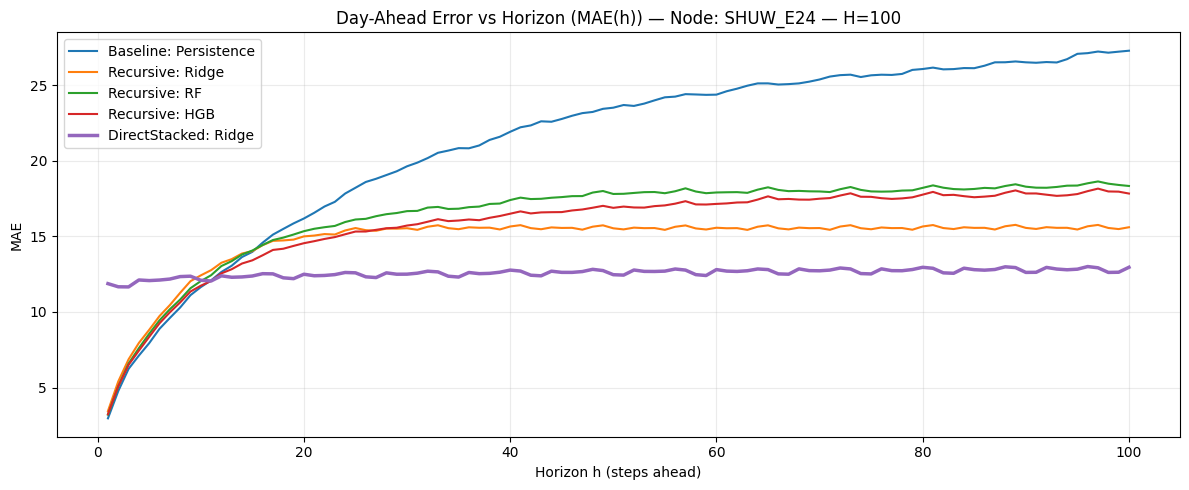

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(np.arange(1, H+1), baseline_mae_h, label="Baseline: Persistence")

for r in final_rows:
    key = f"Recursive_{r['model']}"
    plt.plot(np.arange(1, H+1), final_curves[key], label=f"Recursive: {r['model']}")

plt.plot(np.arange(1, H+1), direct_mae_h, linewidth=2.5, label=f"DirectStacked: {best_model_name}")

plt.title(f"Day-Ahead Error vs Horizon (MAE(h)) — Node: {high_node} — H={H}")
plt.xlabel("Horizon h (steps ahead)")
plt.ylabel("MAE")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


Die Abbildung zeigt den mittleren absoluten Fehler in Abhängigkeit vom Prognoseschritt \(h\) im Day-Ahead-Horizont. Erwartungsgemäß nimmt der Fehler mit zunehmendem Vorlauf insgesamt zu, da Unsicherheit und Dynamikanteile steigen und kurzfristige Persistenzannahmen an Aussagekraft verlieren.

Die Persistenzbaseline weist einen deutlich ansteigenden Fehlerverlauf über den Horizont auf. Dieser Verlauf verdeutlicht, dass das Fortschreiben des letzten Messwerts insbesondere im späteren Day-Ahead-Bereich zunehmend ungeeignet ist.

Die rekursiven Modelle liegen über weite Teile des Horizonts unterhalb der Baseline. Gleichzeitig ist bei allen rekursiven Varianten eine sichtbare Fehlerzunahme mit wachsendem Vorlauf erkennbar, was konsistent zur Fehlerfortpflanzung im rekursiven Multi-Step-Verfahren ist: Vorhersagen werden schrittweise in die Eingabe zurückgeführt und beeinflussen damit die nachfolgenden Prognosen.

Der direkte Multi-Horizon-Ansatz zeigt im Vergleich dazu einen deutlich stabileren Fehlerverlauf über den gesamten Horizont. Insbesondere im späteren Day-Ahead-Bereich bleibt der Fehler auf einem relativ konstanten Niveau und liegt klar unter den rekursiven Kurven. Dies ist plausibel, da der direkte Ansatz die horizonabhängige Beziehung zwischen Eingangsmerkmalen und Zielwerten explizit modelliert und keine rekursive Rückkopplung eigener Vorhersagen nutzt.

Insgesamt unterstützt der Verlauf von \(MAE(h)\) die tabellarischen Gesamtergebnisse: Während die Unterschiede zwischen den Methoden im frühen Horizont geringer ausfallen, trennt sich die Leistungsfähigkeit im weiteren Verlauf deutlich, wobei der direkte Multi-Horizon-Ansatz die robusteste Day-Ahead-Qualität über den gesamten Vorhersagebereich zeigt.


## 18. Zusammenfassende Einordnung der Ergebnisse


In [18]:
print("\nBest model (TRAIN ranking):", best_model_name)
print("Baseline (holdout):", baseline_overall)
print("DirectStacked (holdout):", {k: direct_summary[k] for k in ["MAE","RMSE","R2","Skill_vs_Persistence"]})



Best model (TRAIN ranking): Ridge
Baseline (holdout): {'MAE': 21.237164721298736, 'RMSE': 28.998158055593237, 'R2': -0.03752217787749723}
DirectStacked (holdout): {'MAE': 12.577996929675292, 'RMSE': 16.850050998601603, 'R2': 0.6496847828180219, 'Skill_vs_Persistence': 0.4077365272276281}


Das im Trainingszeitraum anhand der rekursiven Day-Ahead-Leistung ausgewählte Modell ist ein linearer, regularisierter Ansatz. Diese Entscheidung erweist sich im weiteren Verlauf als konsistent und stabil.

Die Persistenzbaseline zeigt im Holdout eine vergleichsweise geringe Prognosegüte und dient damit als klarer Referenzpunkt für die Einordnung der modellbasierten Verfahren. Der direkte Multi-Horizon-Ansatz auf Basis des ausgewählten Modells erreicht im Holdout eine deutlich verbesserte Prognosequalität und erzielt gegenüber der Baseline einen substantiellen relativen Zugewinn.

Besonders hervorzuheben ist, dass die Modellauswahl vollständig im Trainingszeitraum erfolgt und die Holdout-Ergebnisse ausschließlich der finalen Bewertung dienen. Die konsistente Überlegenheit des direkten Multi-Horizon-Ansatzes im Holdout bestätigt, dass der explizite Einbezug des Prognosehorizonts einen wesentlichen Beitrag zur Stabilisierung der Day-Ahead-Prognose leistet.

Damit schließt das Experiment mit einer klaren Ergebnislage: Während das rekursive Verfahren eine solide Referenz darstellt, bietet der direkte Multi-Horizon-Ansatz die robusteste und leistungsfähigste Lösung für die betrachtete Day-Ahead-Lastprognose.
